In [130]:
# code based on SER_edgesw_convert2counts.py to extract matrix of discretized SER counts
# Initial exploration of manifold learning in graph space

In [131]:
import pandas as pd
import os
import os.path, sys
import shutil
import glob
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

from scipy.spatial import Delaunay
import networkx as nx
from matplotlib.collections import LineCollection
import six.moves.cPickle as pickle
import gzip

from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.offsetbox import TextArea, AnnotationBbox
from sklearn import random_projection, manifold

# Scale and visualize the embedding vectors
def plot_embedding(X, y, pddata, title=None,  plotextra=False):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib import offsetbox
    from matplotlib.offsetbox import TextArea, AnnotationBbox
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(12, 8)) 
    ax = plt.subplot(111)
    # process labels 
    classes = [str(c) for c in np.unique(y)]
    colors=plt.cm.rainbow(np.linspace(0,1,len(classes)))
    c_patchs = []
    for k in range(len(classes)):
         c_patchs.append(mpatches.Patch(color=colors[k], label=classes[k]))
    plt.legend(handles=c_patchs)
    
    for i in range(X.shape[0]):
        for k in range(len(classes)):
            if str(y[i])==classes[k]: 
                colori = colors[k] 
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=colori,
                 fontdict={'weight': 'bold', 'size': 10})

        # only print thumbnails with matplotlib > 1.0
        if(plotextra):
            shown_images = np.array([[1., 1.]])  # just something big
            for i in range(X.shape[0]):
                dist = np.sum((X[i] - shown_images) ** 2, 1)
                if np.min(dist) < 4e-3:
                    # don't show points that are too close
                    continue
                shown_images = np.r_[shown_images, [X[i]]]
                offsetbox = TextArea(pddata['type'][i], minimumdescent=False)
                extraLabelbox = AnnotationBbox(offsetbox, X[i], arrowprops=dict(arrowstyle="->"))
                ax.add_artist(extraLabelbox)
    
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)
    if title is not None:
        plt.title(title)

In [132]:
####################
# to load SERw matrices for all lesions
# normalized SER counts
####################
SER_edgesw_path = 'Z:\\Cristina\\Section3\\breast_MR_pipeline\\lesion_SER_edgesw'
with gzip.open(os.path.join(SER_edgesw_path,'allLesions_10binsizenormSERcounts_probC_x.pklz'), 'rb') as fu:
    normSERcounts = pickle.load(fu)

with gzip.open(os.path.join(SER_edgesw_path,'allLesions_10binsizedatanormSERcounts_probC_x.pklz'), 'rb') as fu:
    datanormSERcounts = pickle.load(fu)

print datanormSERcounts.describe()

                                                SERcounts class  type
count                                                 278   278   278
unique                                                278     2     3
top     [0.143646, 0.270718, 0.342541, 0.0441989, 0.01...     B  mass
freq                                                    1   153   190


In [133]:
# set up some parameters and define labels
X = np.asarray(normSERcounts)
print"Input data to t-SNE is mxn-dimensional with m = %i discretized SER bins" % X.shape[1]
print"Input data to t-SNE is mxn-dimensional with n = %i cases" % X.shape[0]
y =  datanormSERcounts['class'].values
y2 = datanormSERcounts['type'].values
n_neighbors = 10

Input data to t-SNE is mxn-dimensional with m = 9 discretized SER bins
Input data to t-SNE is mxn-dimensional with n = 278 cases


# t-distributed Stochastic Neighbor Embedding (t-SNE)
source: Original research presented at ICML 2008
Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.

t-SNE (TSNE) converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:

* Revealing the structure at many scales on a single map
* Revealing data that lie in multiple, different, manifolds or clusters
* Reducing the tendency to crowd points together at the center

The Kullback-Leibler (KL) divergence of the joint probabilities in the original space and the embedded space will be minimized by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initializations will end up in local minima of the KL divergence. Hence, it is sometimes useful to try different seeds and select the embedding with the lowest KL divergence.

#### Optimizing t-SNE
The optimization consists of two phases: the early exaggeration phase and the final optimization. 
There are five parameters that control the optimization of t-SNE and therefore possibly the quality of the resulting embedding:

#### * perplexity: float, optional (default: 30)
Defined as $k=2^(S)$ where S is the Shannon entropy of the conditional probability distribution.
perplexity is effectively the number of nearest neighbors t-SNE considers when generating the conditional probabilities. 
Larger perplexities lead to more nearest neighbors and less sensitive to small structure.
 
#### * early exaggeration factor: float, optional (default: 4.0)
During early exaggeration the joint probabilities in the original space will be artificially increased by multiplication with a given factor. Larger factors result in larger gaps between natural clusters in the data. If the factor is too high, the KL divergence could increase during this phase. Usually it does not have to be tuned.

#### * learning rate: float, optional (default: 1000)
A critical parameter is the learning rate. If it is too low gradient descent will get stuck in a bad local minimum. If it is too high the KL divergence will increase during optimization.  It should be between 100 and 1000. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high. If the cost function gets stuck in a bad local minimum increasing the learning rate helps sometimes.

#### * maximum number of iterations: int, optional (default: 1000)
The maximum number of iterations is usually high enough and does not need any tuning.

#### * angle (not used in the exact method):
angle, is a tradeoff between performance and accuracy. Larger angles imply that we can approximate larger regions by a single point,leading to better speed but less accurate results.


### Other parameters:
##### metric : string or callable, optional
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

##### init : string or numpy array, optional (default: “random”)
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

##### method : string (default: ‘barnes_hut’)
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.
New in version 0.17: Approximate optimization method via the Barnes-Hut.

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 278 / 278
[t-SNE] Mean sigma: 0.054920
[t-SNE] Iteration 25: error = 44.8751664, gradient norm = 0.1726687
[t-SNE] Iteration 50: error = 41.4062252, gradient norm = 0.1666577
[t-SNE] Iteration 75: error = 42.2024088, gradient norm = 0.1340772
[t-SNE] Iteration 100: error = 40.1257378, gradient norm = 0.1253039
[t-SNE] Error after 100 iterations with early exaggeration: 40.125738
[t-SNE] Iteration 125: error = 1.5978044, gradient norm = 0.0239926
[t-SNE] Iteration 150: error = 1.4950381, gradient norm = 0.0240069
[t-SNE] Iteration 175: error = 1.7321940, gradient norm = 0.0278317
[t-SNE] Iteration 200: error = 1.6996033, gradient norm = 0.0186807
[t-SNE] Iteration 225: error = 1.2630163, gradient norm = 0.0124152
[t-SNE] Iteration 250: error = 1.2313866, gradient norm = 0.0118714
[t-SNE] Iteration 275: error = 1.0577333, gradient norm = 0.0071618
[t-SNE] Iteration 300: error = 0.9547010, gradie

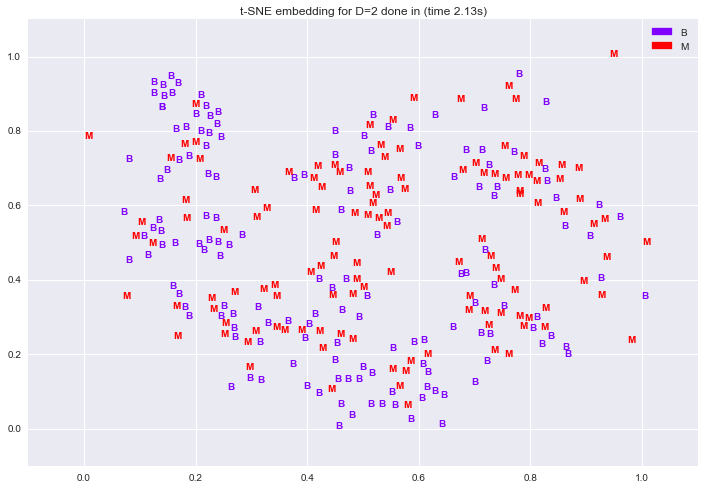

In [134]:
# For a d-dimensional manifold embedded in a D-dimensional parameter space, 
# the reconstruction error will decrease as n_components is increased until n_components == d.
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=12, early_exaggeration=8, learning_rate=700, 
                     init='pca', random_state=0, verbose=2, method='exact')
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, y, datanormSERcounts,
               title="t-SNE embedding for D=2 done in (time %.2fs)" % (time() - t0),
               plotextra=False)


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 278 / 278
[t-SNE] Mean sigma: 0.054920
[t-SNE] Iteration 25: error = 44.8751664, gradient norm = 0.1726687
[t-SNE] Iteration 50: error = 41.4062252, gradient norm = 0.1666577
[t-SNE] Iteration 75: error = 42.2024088, gradient norm = 0.1340772
[t-SNE] Iteration 100: error = 40.1257378, gradient norm = 0.1253039
[t-SNE] Error after 100 iterations with early exaggeration: 40.125738
[t-SNE] Iteration 125: error = 1.5978044, gradient norm = 0.0239926
[t-SNE] Iteration 150: error = 1.4950381, gradient norm = 0.0240069
[t-SNE] Iteration 175: error = 1.7321940, gradient norm = 0.0278317
[t-SNE] Iteration 200: error = 1.6996033, gradient norm = 0.0186807
[t-SNE] Iteration 225: error = 1.2630163, gradient norm = 0.0124152
[t-SNE] Iteration 250: error = 1.2313866, gradient norm = 0.0118714
[t-SNE] Iteration 275: error = 1.0577333, gradient norm = 0.0071618
[t-SNE] Iteration 300: error = 0.9547010, gradie

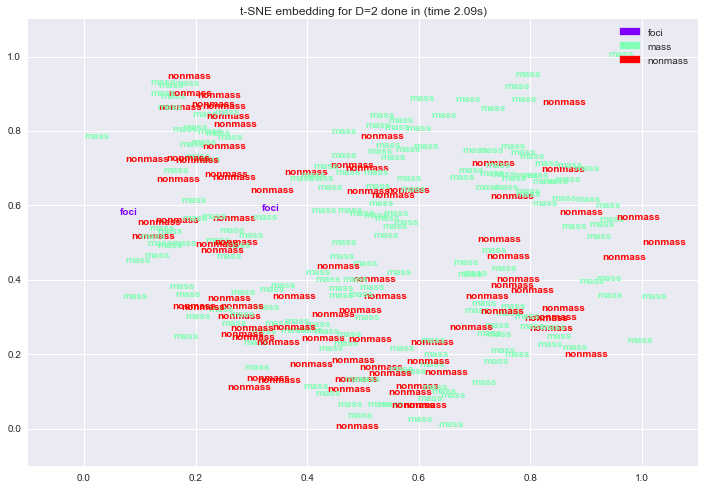

In [135]:
tsne = TSNE(n_components=2, perplexity=12, early_exaggeration=8, learning_rate=700, 
                     init='pca', random_state=0, verbose=2, method='exact')
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, y2, datanormSERcounts,
               title="t-SNE embedding for D=2 done in (time %.2fs)" % (time() - t0),
               plotextra=False)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 278 / 278
[t-SNE] Mean sigma: 0.054920
[t-SNE] Iteration 25: error = 44.8751664, gradient norm = 0.1726687
[t-SNE] Iteration 50: error = 41.4062252, gradient norm = 0.1666577
[t-SNE] Iteration 75: error = 42.2024088, gradient norm = 0.1340772
[t-SNE] Iteration 100: error = 40.1257378, gradient norm = 0.1253039
[t-SNE] Error after 100 iterations with early exaggeration: 40.125738
[t-SNE] Iteration 125: error = 1.5978044, gradient norm = 0.0239926
[t-SNE] Iteration 150: error = 1.4950381, gradient norm = 0.0240069
[t-SNE] Iteration 175: error = 1.7321940, gradient norm = 0.0278317
[t-SNE] Iteration 200: error = 1.6996033, gradient norm = 0.0186807
[t-SNE] Iteration 225: error = 1.2630163, gradient norm = 0.0124152
[t-SNE] Iteration 250: error = 1.2313866, gradient norm = 0.0118714
[t-SNE] Iteration 275: error = 1.0577333, gradient norm = 0.0071618
[t-SNE] Iteration 300: error = 0.9547010, gradie

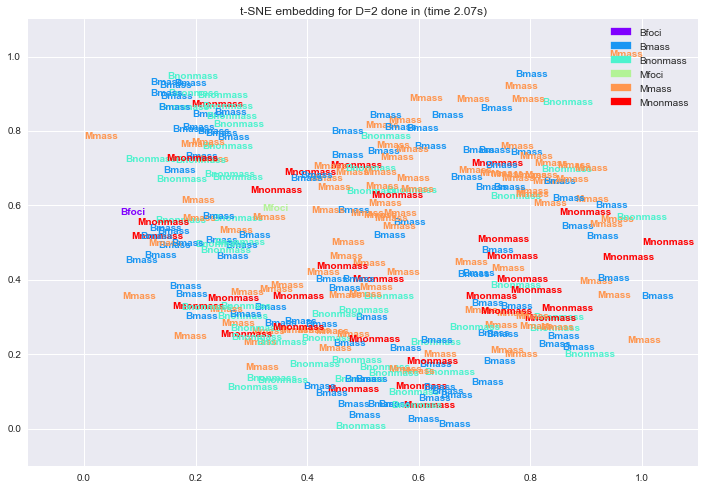

In [136]:
tsne = TSNE(n_components=2, perplexity=12, early_exaggeration=8, learning_rate=700, 
                     init='pca', random_state=0, verbose=2, method='exact')
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, y+y2, datanormSERcounts,
               title="t-SNE embedding for D=2 done in (time %.2fs)" % (time() - t0),
               plotextra=False)

# Analyzing only nonmasses

In [137]:
# subset only nonmasses
Xnonmass = X[datanormSERcounts['type'].values=='nonmass',:]
ynonmass =  datanormSERcounts['class'].values[datanormSERcounts['type'].values=='nonmass']
datanonmass = datanormSERcounts[datanormSERcounts['type'].values=='nonmass']
print datanonmass.describe()


                                                SERcounts class     type
count                                                  86    86       86
unique                                                 86     2        1
top     [0.515, 0.218333, 0.08, 0.0433333, 0.0266667, ...     B  nonmass
freq                                                    1    54       86


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 86 / 86
[t-SNE] Mean sigma: 0.063118
[t-SNE] Iteration 25: error = 50.3675490, gradient norm = 0.5282138
[t-SNE] Iteration 50: error = 48.6019581, gradient norm = 0.5109727
[t-SNE] Iteration 75: error = 49.4157079, gradient norm = 0.4248788
[t-SNE] Iteration 100: error = 46.1615564, gradient norm = 0.4294088
[t-SNE] Error after 100 iterations with early exaggeration: 46.161556
[t-SNE] Iteration 125: error = 0.8209019, gradient norm = 0.0208890
[t-SNE] Iteration 150: error = 0.4929015, gradient norm = 0.0084448
[t-SNE] Iteration 175: error = 0.4481950, gradient norm = 0.0026680
[t-SNE] Iteration 200: error = 0.4318763, gradient norm = 0.0044439
[t-SNE] Iteration 225: error = 0.4248187, gradient norm = 0.0036404
[t-SNE] Iteration 250: error = 0.4232412, gradient norm = 0.0034837
[t-SNE] Iteration 275: error = 0.4228238, gradient norm = 0.0034460
[t-SNE] Iteration 300: error = 0.4227090, gradient

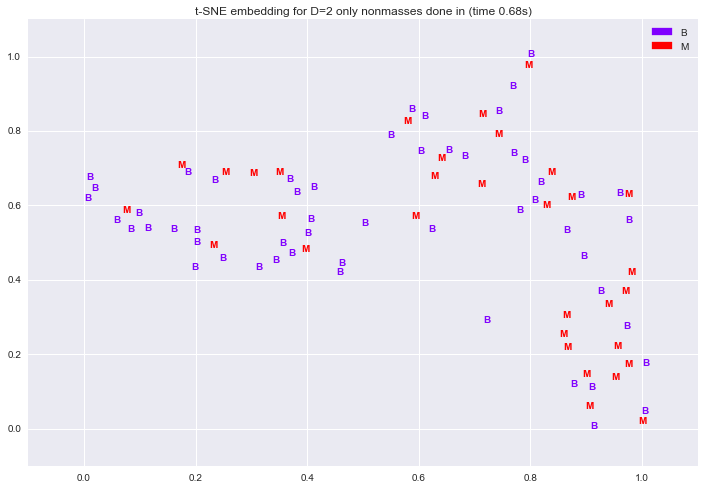

In [138]:
tsne = TSNE(n_components=2, perplexity=8, early_exaggeration=10, learning_rate=80, 
                     init='pca', random_state=0, verbose=2, method='exact')
t0 = time()
X_tsne = tsne.fit_transform(Xnonmass)

plot_embedding(X_tsne, ynonmass, datanonmass,
               title="t-SNE embedding for D=2 only nonmasses done in (time %.2fs)" % (time() - t0),
               plotextra=False)

# Incorporating graph features

In [139]:
# to load all nxGdatafeatures
nxGfeatures_path = 'Z:\\Cristina\\Section3\\breast_MR_pipeline\\lesion_nxGfeatures'
with gzip.open(os.path.join(nxGfeatures_path,'nxGdatafeatures_allLesions_10binsize.pklz'), 'rb') as fu:
    nxGdatafeatures = pickle.load(fu)

with gzip.open(os.path.join(nxGfeatures_path,'nxGnormfeatures_allLesions_10binsize.pklz'), 'rb') as fu:
    nxGnormfeatures = pickle.load(fu)


Input data to t-SNE is mxn-dimensional with m = 101 discretized SER bins
Input data to t-SNE is mxn-dimensional with n = 278 cases
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 278 / 278
[t-SNE] Mean sigma: 0.840963
[t-SNE] Iteration 25: error = 35.7250476, gradient norm = 0.2309808
[t-SNE] Iteration 50: error = 35.6295262, gradient norm = 0.1987190
[t-SNE] Iteration 75: error = 33.8701667, gradient norm = 0.1701926
[t-SNE] Iteration 100: error = 34.2216634, gradient norm = 0.1524094
[t-SNE] Error after 100 iterations with early exaggeration: 34.221663
[t-SNE] Iteration 125: error = 0.8710755, gradient norm = 0.0139997
[t-SNE] Iteration 150: error = 0.6090058, gradient norm = 0.0093010
[t-SNE] Iteration 175: error = 0.5445210, gradient norm = 0.0113973
[t-SNE] Iteration 200: error = 0.5341883, gradient norm = 0.0149443
[t-SNE] Iteration 225: error = 0.5351255, gradient norm = 0.0158041
[t-SNE] Iteration 250: error = 0.5709258, gradient no

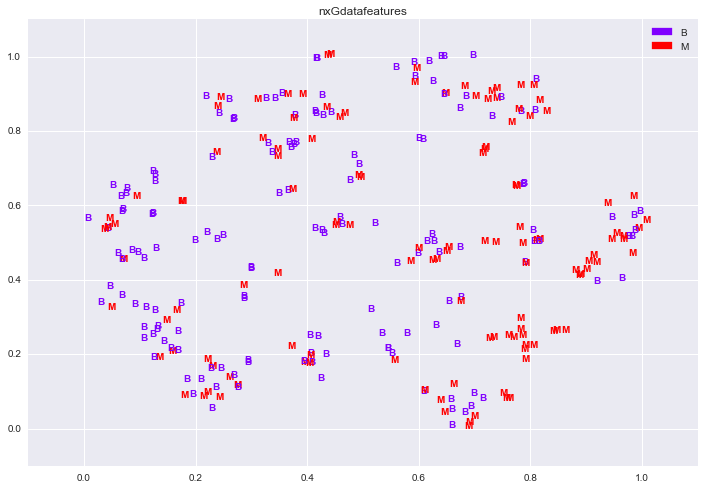

In [140]:
# set up some parameters and define labels
X = nxGnormfeatures
print"Input data to t-SNE is mxn-dimensional with m = %i discretized SER bins" % X.shape[1]
print"Input data to t-SNE is mxn-dimensional with n = %i cases" % X.shape[0]
y =  nxGdatafeatures['class'].values
y2 = nxGdatafeatures['type'].values

tsne = TSNE(n_components=2, perplexity=9, early_exaggeration=7, learning_rate=320, 
             init='pca', random_state=0, verbose=2, method='exact')     
X_tsne = tsne.fit_transform(X)
y_tsne = y #y2+y

## plot TSNE
plot_embedding(X_tsne, y, nxGdatafeatures, title='nxGdatafeatures',  plotextra=False)

In [141]:
## adding SERedgew
combX = np.concatenate((nxGnormfeatures, np.asarray(normSERcounts)), axis=1)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 278 / 278
[t-SNE] Mean sigma: 0.851536
[t-SNE] Iteration 25: error = 36.5033846, gradient norm = 0.2191689
[t-SNE] Iteration 50: error = 34.6494564, gradient norm = 0.2058741
[t-SNE] Iteration 75: error = 33.2188534, gradient norm = 0.1887798
[t-SNE] Iteration 100: error = 32.6830457, gradient norm = 0.1661207
[t-SNE] Error after 100 iterations with early exaggeration: 32.683046
[t-SNE] Iteration 125: error = 0.7818148, gradient norm = 0.0134907
[t-SNE] Iteration 150: error = 0.5712859, gradient norm = 0.0119459
[t-SNE] Iteration 175: error = 0.5610554, gradient norm = 0.0123077
[t-SNE] Iteration 200: error = 0.5829729, gradient norm = 0.0120610
[t-SNE] Iteration 225: error = 0.5666949, gradient norm = 0.0126721
[t-SNE] Iteration 250: error = 0.5681209, gradient norm = 0.0164988
[t-SNE] Iteration 250: did not make any progress during the last 50 episodes. Finished.
[t-SNE] Error after 250 iter

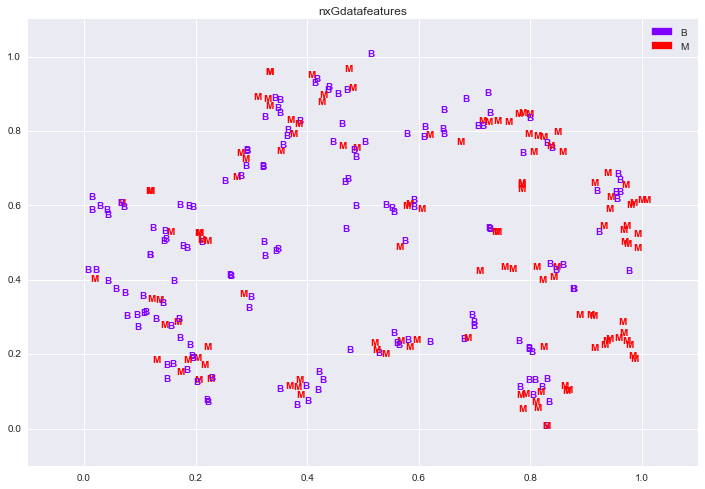

In [142]:
tsne = TSNE(n_components=2, perplexity=9, early_exaggeration=7, learning_rate=320, 
                 init='pca', random_state=0, verbose=2, method='exact')    
X_tsne = tsne.fit_transform(combX)
y_tsne = y #y2+y

## plot TSNE
plot_embedding(X_tsne, y_tsne, nxGdatafeatures, title='nxGdatafeatures',  plotextra=False)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 278 / 278
[t-SNE] Mean sigma: 0.851536
[t-SNE] Iteration 25: error = 36.5033846, gradient norm = 0.2191689
[t-SNE] Iteration 50: error = 34.6494564, gradient norm = 0.2058741
[t-SNE] Iteration 75: error = 33.2188534, gradient norm = 0.1887798
[t-SNE] Iteration 100: error = 32.6830457, gradient norm = 0.1661207
[t-SNE] Error after 100 iterations with early exaggeration: 32.683046
[t-SNE] Iteration 125: error = 0.7818148, gradient norm = 0.0134907
[t-SNE] Iteration 150: error = 0.5712859, gradient norm = 0.0119459
[t-SNE] Iteration 175: error = 0.5610554, gradient norm = 0.0123077
[t-SNE] Iteration 200: error = 0.5829729, gradient norm = 0.0120610
[t-SNE] Iteration 225: error = 0.5666949, gradient norm = 0.0126721
[t-SNE] Iteration 250: error = 0.5681209, gradient norm = 0.0164988
[t-SNE] Iteration 250: did not make any progress during the last 50 episodes. Finished.
[t-SNE] Error after 250 iter

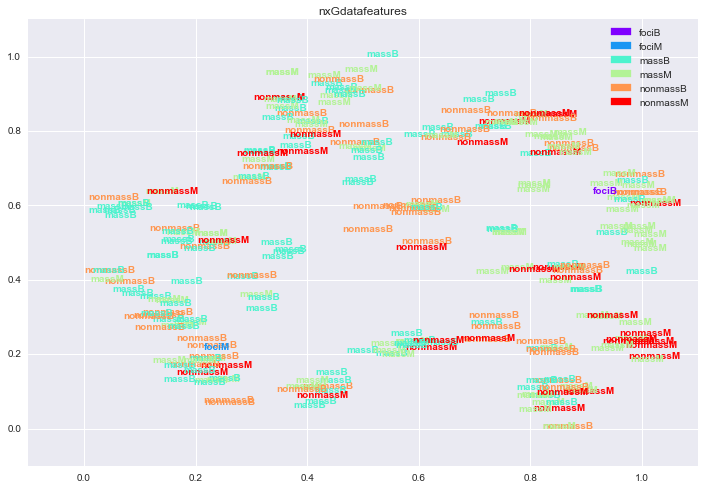

In [143]:
tsne = TSNE(n_components=2, perplexity=9, early_exaggeration=7, learning_rate=320, 
                 init='pca', random_state=0, verbose=2, method='exact')      
X_tsne = tsne.fit_transform(combX)
y_tsne = y2+y

## plot TSNE
plot_embedding(X_tsne, y_tsne, nxGdatafeatures, title='nxGdatafeatures',  plotextra=False)

# analyze only for nonmasses

In [144]:
# subset only nonmasses
XnonmassSER = np.asarray(normSERcounts)[datanormSERcounts['type'].values=='nonmass',:]
ynonmass =  datanormSERcounts['class'].values[datanormSERcounts['type'].values=='nonmass']
datanonmass = datanormSERcounts[datanormSERcounts['type'].values=='nonmass']
print"Input data to t-SNE is mxn-dimensional with m = %i discretized SER bins" % XnonmassSER.shape[1]
print"Input data to t-SNE is mxn-dimensional with n = %i cases" % XnonmassSER.shape[0]

Input data to t-SNE is mxn-dimensional with m = 9 discretized SER bins
Input data to t-SNE is mxn-dimensional with n = 86 cases


In [145]:
# subset only nonmasses
XnonmassnxG = nxGnormfeatures[datanormSERcounts['type'].values=='nonmass',:]
ynonmass =  datanormSERcounts['class'].values[datanormSERcounts['type'].values=='nonmass']
datanonmass = datanormSERcounts[datanormSERcounts['type'].values=='nonmass']
print"Input data to t-SNE is mxn-dimensional with m = %i nxG features" % XnonmassnxG.shape[1]
print"Input data to t-SNE is mxn-dimensional with n = %i cases" % XnonmassnxG.shape[0]


Input data to t-SNE is mxn-dimensional with m = 101 nxG features
Input data to t-SNE is mxn-dimensional with n = 86 cases


In [146]:
combXnonmass = np.concatenate((XnonmassSER, XnonmassnxG), axis=1)
print"Input data to t-SNE is mxn-dimensional with m = %i combined SER + nxG features" % combXnonmass.shape[1]
print"Input data to t-SNE is mxn-dimensional with n = %i cases" % combXnonmass.shape[0]

Input data to t-SNE is mxn-dimensional with m = 110 combined SER + nxG features
Input data to t-SNE is mxn-dimensional with n = 86 cases


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 86 / 86
[t-SNE] Mean sigma: 0.858005
[t-SNE] Iteration 25: error = 36.7658328, gradient norm = 0.3510154
[t-SNE] Iteration 50: error = 34.8566012, gradient norm = 0.3900112
[t-SNE] Iteration 75: error = 32.6323806, gradient norm = 0.3127691
[t-SNE] Iteration 100: error = 32.9996217, gradient norm = 0.3121799
[t-SNE] Error after 100 iterations with early exaggeration: 32.999622
[t-SNE] Iteration 125: error = 0.9976946, gradient norm = 0.0360598
[t-SNE] Iteration 150: error = 0.7441659, gradient norm = 0.0253241
[t-SNE] Iteration 175: error = 0.7719116, gradient norm = 0.0495294
[t-SNE] Iteration 200: error = 0.8262044, gradient norm = 0.0496107
[t-SNE] Iteration 225: error = 0.9141362, gradient norm = 0.0548107
[t-SNE] Iteration 225: did not make any progress during the last 50 episodes. Finished.
[t-SNE] Error after 225 iterations: 0.914136


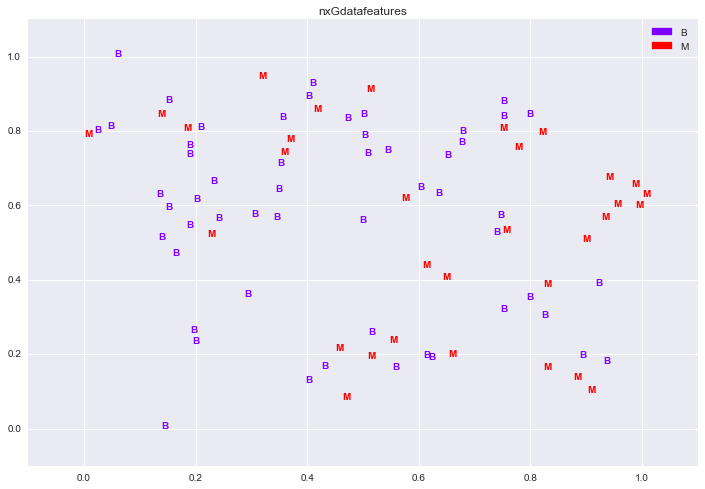

In [147]:
tsne = TSNE(n_components=2, perplexity=4, early_exaggeration=7, learning_rate=80, 
                 init='pca', random_state=0, verbose=2, method='exact')      
X_tsne = tsne.fit_transform(combXnonmass)
y_tsne = ynonmass

## plot TSNE
plot_embedding(X_tsne, y_tsne, nxGdatafeatures, title='nxGdatafeatures',  plotextra=False)